# Convolutional Neural Networks from Scratch (PyTorch-based)

__Notebook Author__: Hamed Qazanfari

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamedmit/VisionLab/blob/main/CNN_from_scratch_torch.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/hamedmit/VisionLab/blob/main/CNN_from_scratch_torch.ipynb)

---

## Notebook Objectives

This notebook implements the same convolutional neural network (CNN) as the previous NumPy-based version (see CNN_from_scratch_numpy.ipynb), but using PyTorch. It follows the same structure, allowing for a direct comparison between the two implementations. The model is trained on the Fashion-MNIST dataset with four selected classes. PyTorch simplifies the process, making model definition, training, and optimization more efficient.



# PyTorch

Here we implement the same CNN but we use PyTorch instead of coding it from scratch.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

In [ ]:
# helper functions

def plot_results(losses, accuracies):
    # Plot the loss
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracies) + 1), accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()
    # Put number of each cell in plot
    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


def get_data(filter_classes):
    fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')
    x, y = fashion_mnist['data'], fashion_mnist['target'].astype(int)
    # Remove classes
    filtered_indices = np.isin(y, filter_classes)
    x, y = x[filtered_indices].to_numpy(), y[filtered_indices]
    # Normalize the pixels to be in [-1, +1] range
    x = ((x / 255.) - .5) * 2
    removed_class_count = 0
    for i in range(10):  # Fix the labels
        if i in filter_classes and removed_class_count != 0:
            y[y == i] = i - removed_class_count
        elif i not in filter_classes:
            removed_class_count += 1
    # Do the train-test split
    return train_test_split(x, y, test_size=10_000)


def onehot_encoder(y, num_labels):
    one_hot = np.zeros(shape=(y.size, num_labels), dtype=int)
    one_hot[np.arange(y.size), y] = 1
    return one_hot

In [ ]:
# dataset

def get_data(filter_classes):
    # Download and prepare the dataset
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # Function to filter dataset and remap labels
    def filter_and_remap(dataset, filter_classes):
        data = dataset.data.numpy()
        targets = dataset.targets.numpy()

        # Remove classes
        filtered_indices = np.isin(targets, filter_classes)
        data, targets = data[filtered_indices], targets[filtered_indices]

        # Normalize the pixels to be in [-1, +1] range
        data = ((data / 255.0) - 0.5) * 2

        # Remap labels
        removed_class_count = 0
        for i in range(10):
            if i in filter_classes and removed_class_count != 0:
                targets[targets == i] = i - removed_class_count
            elif i not in filter_classes:
                removed_class_count += 1

        # Update the dataset
        dataset.data = torch.tensor(data, dtype=torch.float32)
        dataset.targets = torch.tensor(targets, dtype=torch.long)
        return dataset

    # Filter and remap the train and test datasets
    trainset = filter_and_remap(trainset, filter_classes)
    testset = filter_and_remap(testset, filter_classes)

    return trainset, testset
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5:  'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

kept_classes = [0, 1, 4, 7]  # T-shirt/top, Trouser, Coat, Sneaker
trainset, testset = get_data(kept_classes)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
# helper functions CNN

def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images, labels
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, 100 * train_acc

def train_model(model, loader, optimizer, n_epochs):
    losses, accuracies = np.empty(n_epochs), np.empty(n_epochs)
    loss_fn = nn.CrossEntropyLoss()
    for i in (pbar := trange(n_epochs)):
        loss, acc = train_epoch(model, loader, loss_fn, optimizer)
        losses[i], accuracies[i] = loss, acc
        pbar.set_description(f'Loss: {loss:.3f} | Accuracy: {acc:.2f}% ')
    return losses, accuracies

def test_model(model, loader):
    model.eval()
    acc = 0.
    y_test, y_prediction =[], []
    with torch.no_grad():
        for images, labels in loader:
            logits = model(images)
            pred = logits.argmax(dim=1)
            acc += (pred == labels).sum().item()
            y_test.extend(labels.numpy())
            y_prediction.extend(pred.numpy())
    size = len(loader.dataset)
    acc = 100 * acc / size
    print(f'Test accuracy on {size} test samples is {acc:.2f}%')
    return y_test, y_prediction

Loss: 0.321 | Accuracy: 88.58% : 100%|██████████| 30/30 [04:56<00:00,  9.90s/it]


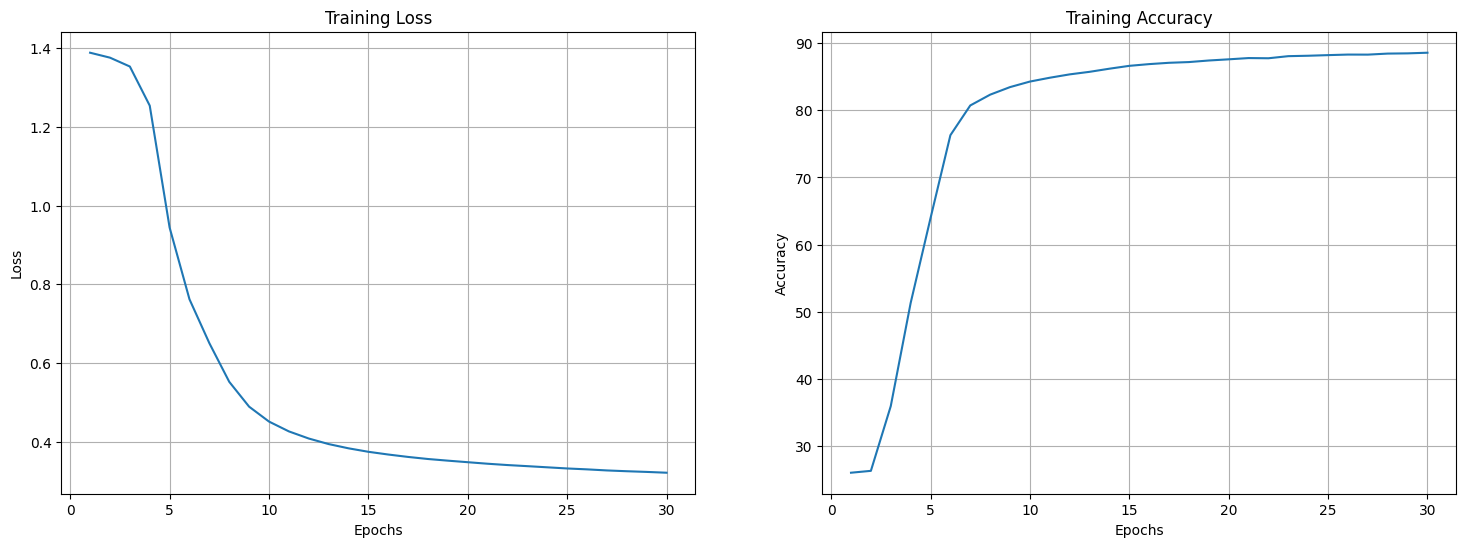

In [12]:
# Create the model
model = nn.Sequential(nn.Conv2d(1, 4, kernel_size=7, stride=3),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Conv2d(4, 4, kernel_size=3, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Flatten(),
                      nn.ReLU(),
                      nn.Linear(16, len(kept_classes)))

# Setup the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the model
results = train_model(model, trainloader, optimizer, n_epochs=30)

# Plot the loss curve and accuracies
plot_results(*results)

Test accuracy on 4000 test samples is 86.33%


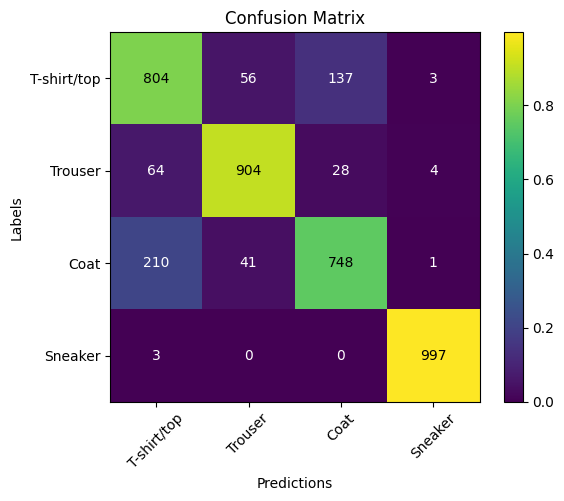

In [15]:
# Test the model
y_test, y_pred = test_model(model, testloader)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, kept_classes)

## Conclusion:
By implementing the CNN in both NumPy and PyTorch, we can observe the differences in manual computation versus framework-based optimization. While NumPy provides a deeper understanding of CNNs at a fundamental level, PyTorch enhances flexibility and efficiency, making it more suitable for real-world applications.